# **Setting up the environment**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
import os
files=os.listdir('/kaggle/input/facial-emotion-recognition/images/0')
emotions=[]
for f in  files:
    emotions+=[f.split('.')[0]]
class_names=sorted(emotions)
!mkdir images
for emo in emotions:
    !mkdir images/{emo}
!ls images

Anger  Contempt  Disgust  Fear	Happy  Neutral	Sad  Surprised


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input/facial-emotion-recognition/images'):
    for filename in filenames:
        path=os.path.join(dirname, filename)
        emo=filename.split('.')[0]
        idi=dirname.split('/')[-1]
        newfile=idi+'_'+filename
        !cp {path} {os.path.join('images',emo,newfile)}

In [5]:
tpath = '/kaggle/working/images'

In [6]:
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size = 4,
    image_size =(224,224),

    shuffle = True,
    seed =42,
    subset ='training',
    validation_split=0.2
    )
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size = 4,
    image_size =(224,224),

    shuffle = True,
    seed =42,
    validation_split =0.2,
    subset ='validation'
    
    )

Found 152 files belonging to 8 classes.
Using 122 files for training.
Found 152 files belonging to 8 classes.
Using 30 files for validation.


# **ResNet-34**

In [7]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [8]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224,224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8, activation="softmax"))

In [9]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01 , rho=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=15  
)

Epoch 1/15
31/31 [==============================] - 35s 164ms/step - loss: 5.9309 - accuracy: 0.1803 - val_loss: 139801.4844 - val_accuracy: 0.1667
Epoch 2/15
31/31 [==============================] - 5s 132ms/step - loss: 2.9478 - accuracy: 0.1148 - val_loss: 67435.7578 - val_accuracy: 0.1000
Epoch 3/15
31/31 [==============================] - 5s 128ms/step - loss: 2.5307 - accuracy: 0.1148 - val_loss: 383230.8125 - val_accuracy: 0.1667
Epoch 4/15
31/31 [==============================] - 5s 131ms/step - loss: 2.2338 - accuracy: 0.0902 - val_loss: 10586.7705 - val_accuracy: 0.1000
Epoch 5/15
31/31 [==============================] - 5s 130ms/step - loss: 2.1420 - accuracy: 0.1230 - val_loss: 219.8929 - val_accuracy: 0.1667
Epoch 6/15
31/31 [==============================] - 5s 144ms/step - loss: 2.1826 - accuracy: 0.1230 - val_loss: 138.4771 - val_accuracy: 0.1000
Epoch 7/15
31/31 [==============================] - 5s 127ms/step - loss: 2.1160 - accuracy: 0.1311 - val_loss: 31.4824 - val

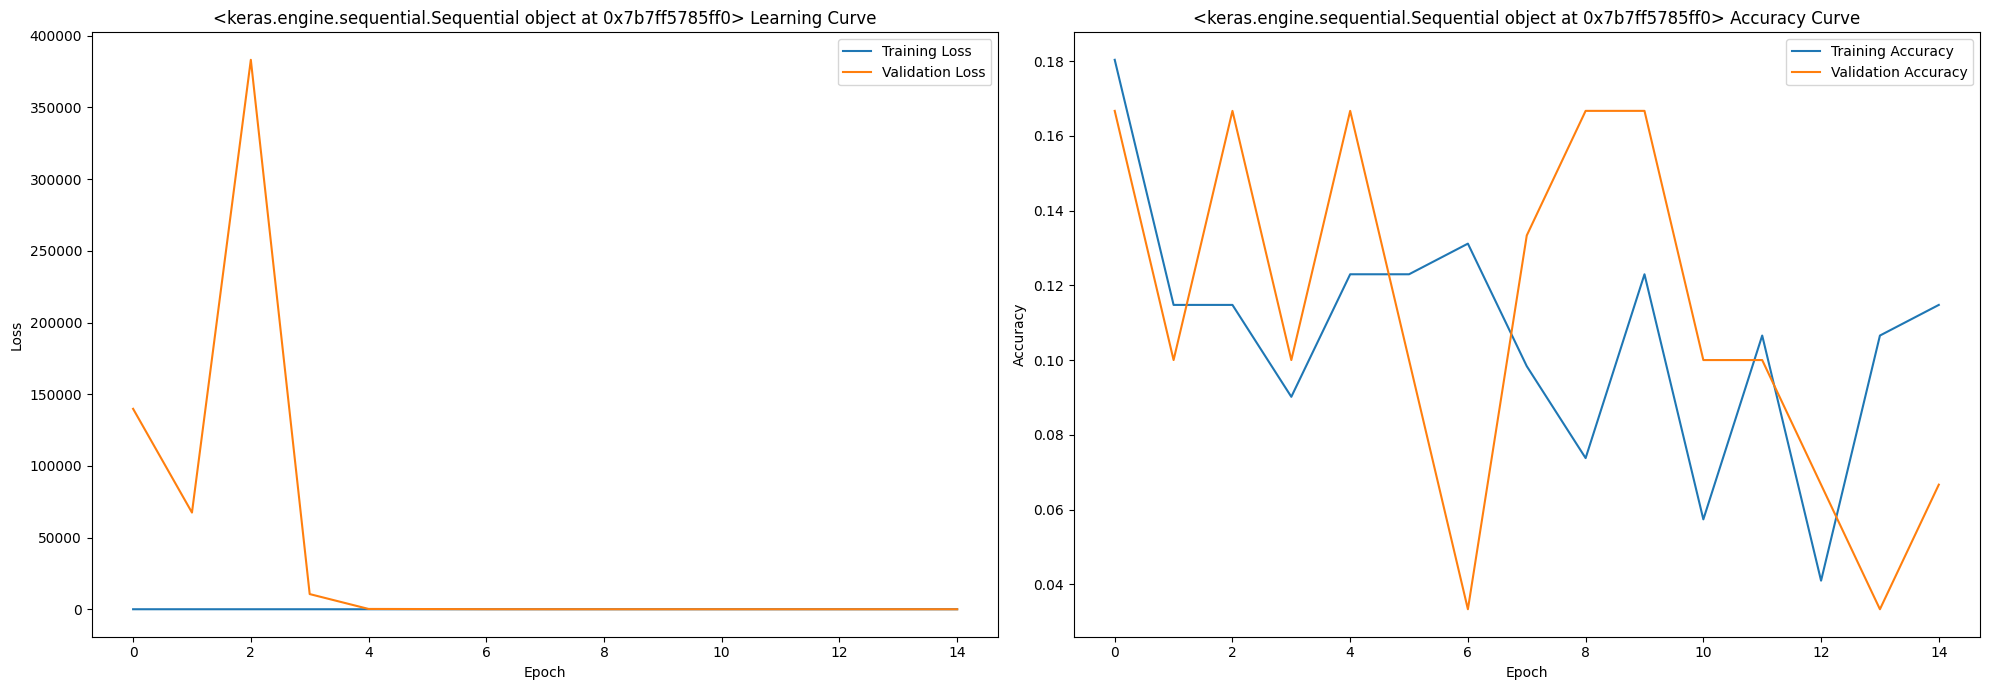

In [10]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

def plot_accuracy_curves(history, model_name, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(f'{model_name} Accuracy Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(20, 7))  
plot_learning_curves(history, model, axs[0])
plot_accuracy_curves(history, model, axs[1])

plt.tight_layout()
plt.show()

# **ResNet-50**

In [11]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224,224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])

residual_blocks = [3, 4, 6, 3]  # ResNet-50 configuration

prev_filters = 64
for filters, blocks in zip([64, 128, 256, 512], residual_blocks):
    for _ in range(blocks):
        if filters != prev_filters:
            strides = 2
        else:
            strides = 1
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(8, activation="softmax"))


In [12]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01 , rho=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=15 
)

Epoch 1/15
31/31 [==============================] - 20s 145ms/step - loss: 7.0886 - accuracy: 0.1230 - val_loss: 68649914368.0000 - val_accuracy: 0.0667
Epoch 2/15
31/31 [==============================] - 5s 128ms/step - loss: 2.7894 - accuracy: 0.1311 - val_loss: 53997.0078 - val_accuracy: 0.1000
Epoch 3/15
31/31 [==============================] - 5s 135ms/step - loss: 2.5043 - accuracy: 0.1148 - val_loss: 18401.2051 - val_accuracy: 0.1667
Epoch 4/15
31/31 [==============================] - 5s 139ms/step - loss: 2.2533 - accuracy: 0.1393 - val_loss: 24574.3340 - val_accuracy: 0.0667
Epoch 5/15
31/31 [==============================] - 5s 132ms/step - loss: 2.2000 - accuracy: 0.1066 - val_loss: 588.3906 - val_accuracy: 0.1000
Epoch 6/15
31/31 [==============================] - 5s 131ms/step - loss: 2.2398 - accuracy: 0.0984 - val_loss: 31099.0312 - val_accuracy: 0.1333
Epoch 7/15
31/31 [==============================] - 5s 133ms/step - loss: 2.1166 - accuracy: 0.0328 - val_loss: 1538.73

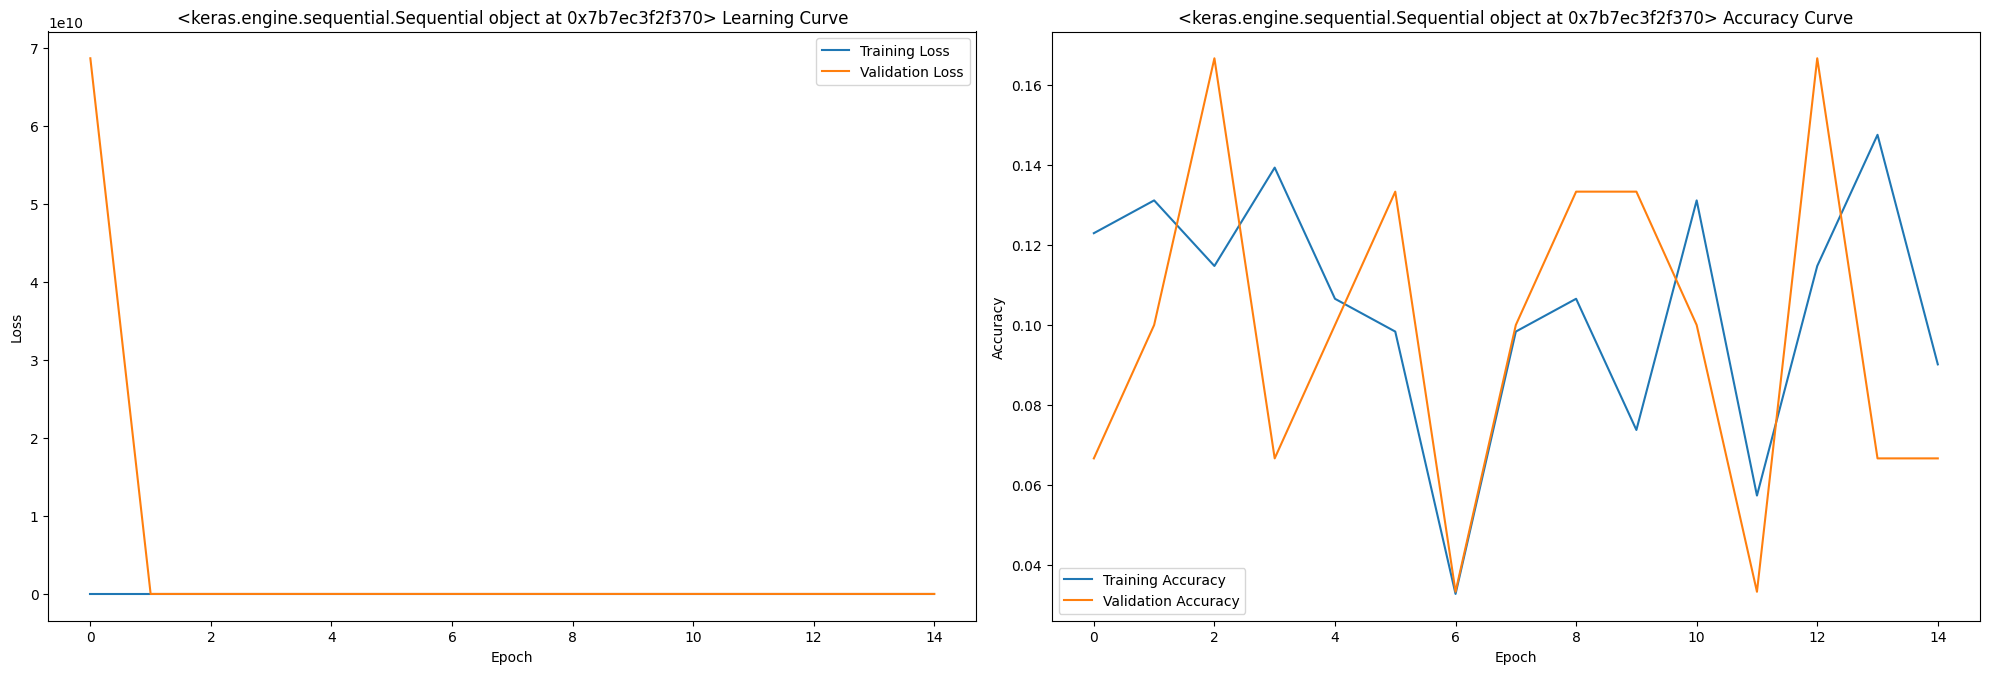

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))  
plot_learning_curves(history, model, axs[0])
plot_accuracy_curves(history, model, axs[1])

plt.tight_layout()
plt.show()

# **ResNet-101**

In [14]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224,224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])

residual_blocks = [3, 4, 23, 3]  # ResNet-101 configuration

prev_filters = 64
for filters, blocks in zip([64, 128, 256, 512], residual_blocks):
    for _ in range(blocks):
        if filters != prev_filters:
            strides = 2
        else:
            strides = 1
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(8, activation="softmax"))

In [15]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01 , rho=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=15  
)

Epoch 1/15
31/31 [==============================] - 35s 177ms/step - loss: 5.7119 - accuracy: 0.1148 - val_loss: 1276155265024.0000 - val_accuracy: 0.1333
Epoch 2/15
31/31 [==============================] - 5s 142ms/step - loss: 2.6624 - accuracy: 0.0902 - val_loss: 31458176.0000 - val_accuracy: 0.0667
Epoch 3/15
31/31 [==============================] - 6s 147ms/step - loss: 2.3309 - accuracy: 0.1311 - val_loss: 150775.2031 - val_accuracy: 0.1333
Epoch 4/15
31/31 [==============================] - 6s 158ms/step - loss: 2.2387 - accuracy: 0.1148 - val_loss: 10781.3477 - val_accuracy: 0.1000
Epoch 5/15
31/31 [==============================] - 5s 140ms/step - loss: 2.1606 - accuracy: 0.1066 - val_loss: 316.6577 - val_accuracy: 0.1333
Epoch 6/15
31/31 [==============================] - 5s 143ms/step - loss: 2.1082 - accuracy: 0.1393 - val_loss: 104.0394 - val_accuracy: 0.1000
Epoch 7/15
31/31 [==============================] - 5s 140ms/step - loss: 2.1859 - accuracy: 0.0738 - val_loss: 112

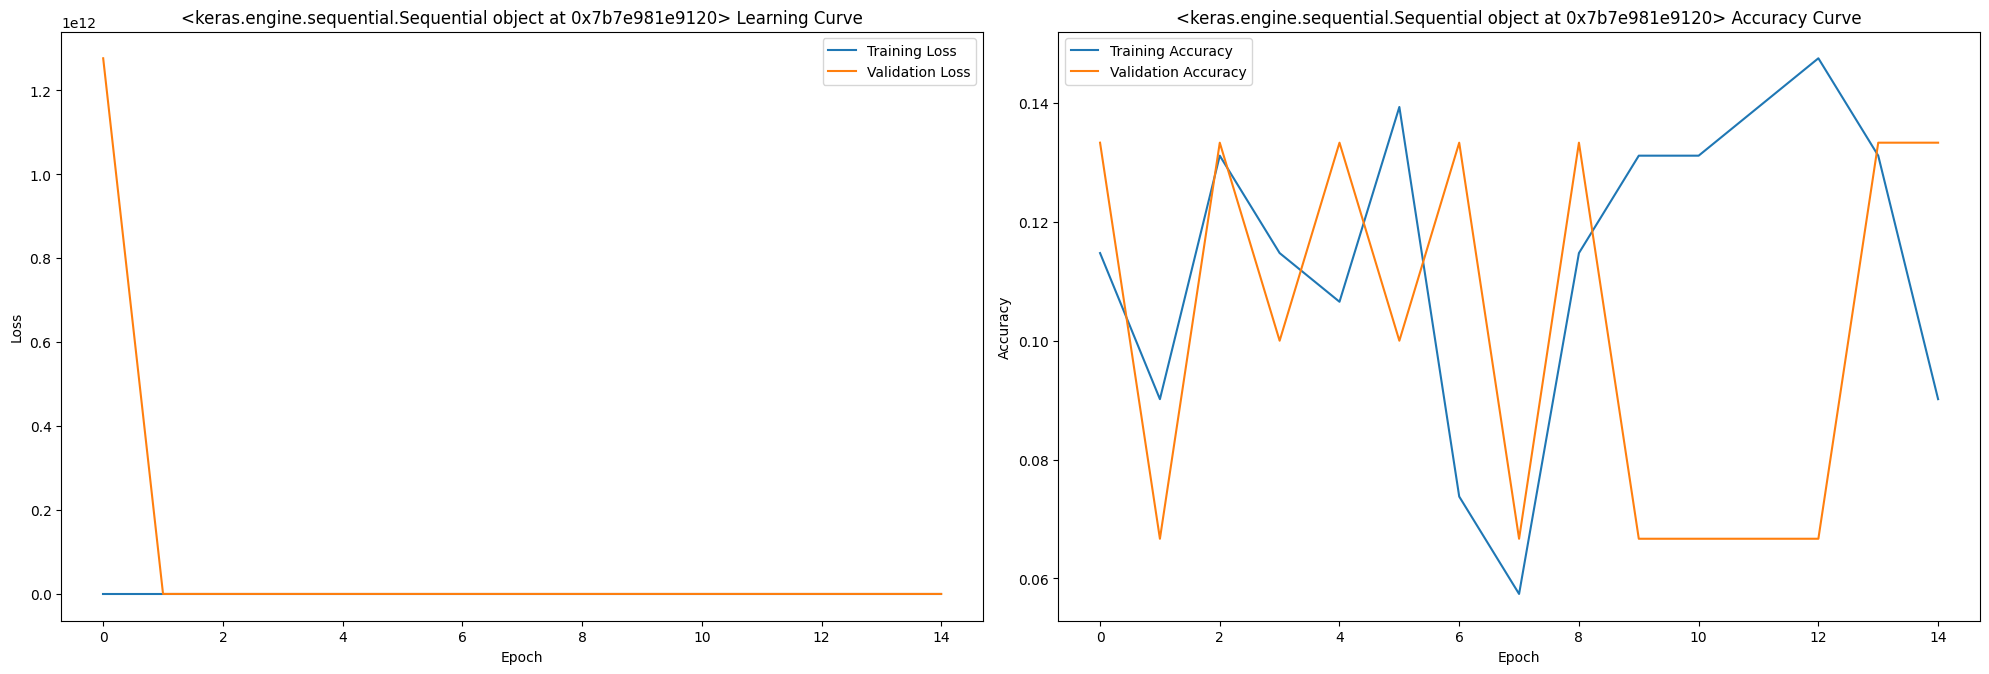

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))  
plot_learning_curves(history, model, axs[0])
plot_accuracy_curves(history, model, axs[1])

plt.tight_layout()
plt.show()

# **ResNet-152**

In [17]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])

residual_blocks = [3, 8, 36, 3]  # ResNet-152 configuration

prev_filters = 64
for filters, blocks in zip([64, 128, 256, 512], residual_blocks):
    for _ in range(blocks):
        if filters != prev_filters:
            strides = 2
        else:
            strides = 1
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(8, activation="softmax"))

In [18]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01 , rho=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=15 
)

Epoch 1/15
31/31 [==============================] - 50s 211ms/step - loss: 5.8286 - accuracy: 0.1148 - val_loss: 128943181004800.0000 - val_accuracy: 0.1667
Epoch 2/15
31/31 [==============================] - 6s 158ms/step - loss: 2.6857 - accuracy: 0.1311 - val_loss: 608110464.0000 - val_accuracy: 0.1667
Epoch 3/15
31/31 [==============================] - 6s 161ms/step - loss: 2.5613 - accuracy: 0.1311 - val_loss: 1956415.8750 - val_accuracy: 0.1000
Epoch 4/15
31/31 [==============================] - 6s 159ms/step - loss: 2.3365 - accuracy: 0.0492 - val_loss: 334.6801 - val_accuracy: 0.0667
Epoch 5/15
31/31 [==============================] - 6s 157ms/step - loss: 2.2083 - accuracy: 0.0902 - val_loss: 82.4158 - val_accuracy: 0.1000
Epoch 6/15
31/31 [==============================] - 6s 171ms/step - loss: 2.1584 - accuracy: 0.1066 - val_loss: 8.5899 - val_accuracy: 0.1333
Epoch 7/15
31/31 [==============================] - 6s 157ms/step - loss: 2.1235 - accuracy: 0.0902 - val_loss: 90.5

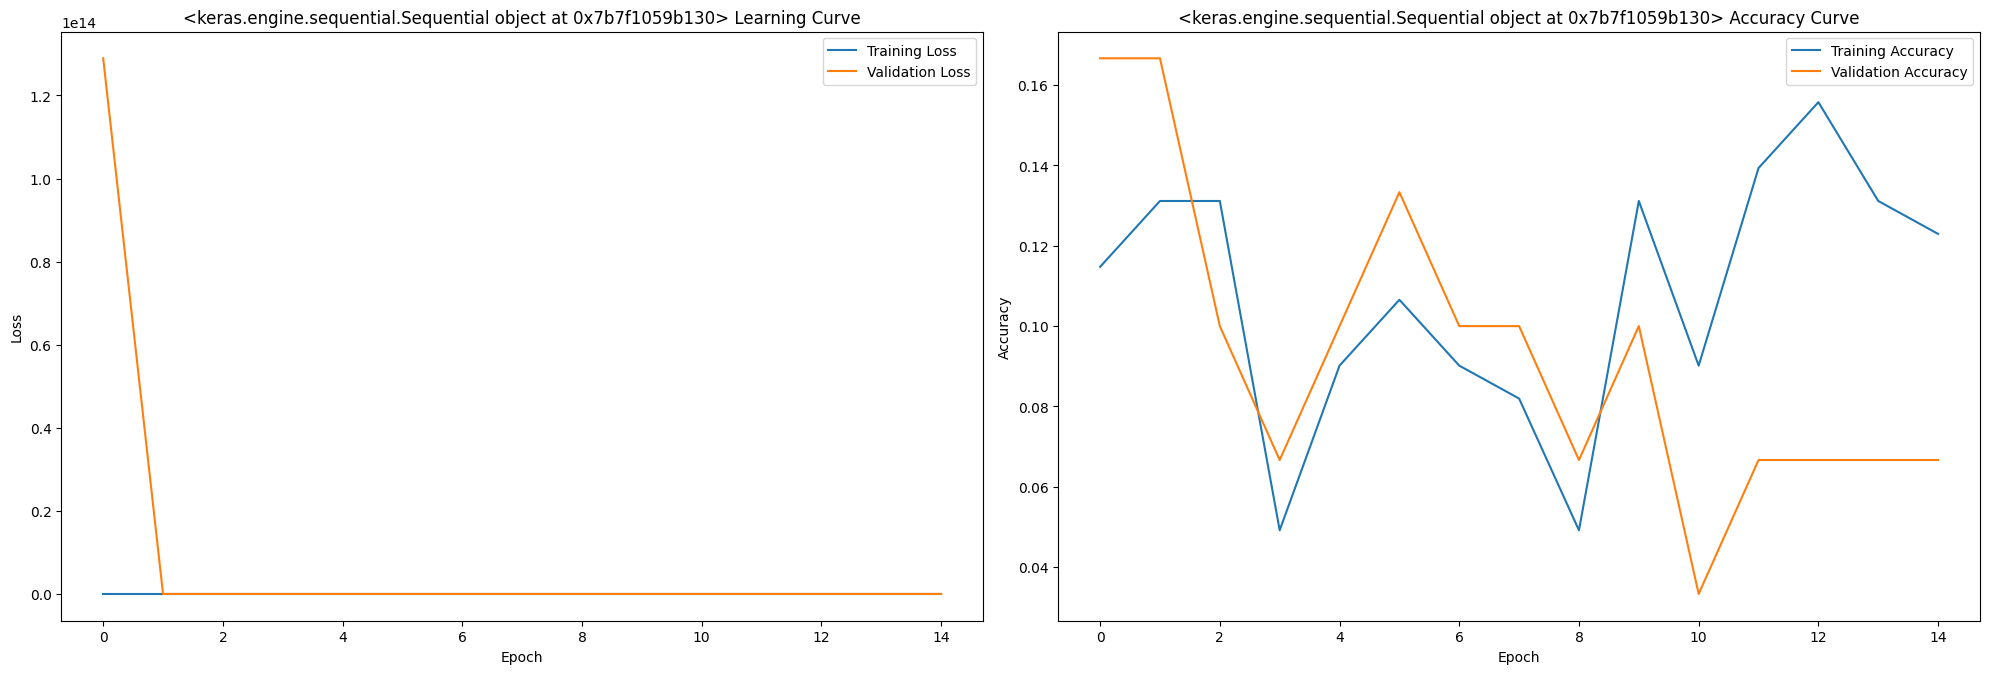

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))  
plot_learning_curves(history, model, axs[0])
plot_accuracy_curves(history, model, axs[1])

plt.tight_layout()
plt.show()